**HOW CNN BETTER THAN ANN**

Spatial Hierarchies and Local Patterns:

1. CNNs: CNNs leverage convolutional layers to detect local patterns in different parts of an image. These layers help capture spatial hierarchies by learning features at various scales.

ANNs: ANNs lack the ability to efficiently capture local patterns and spatial hierarchies in images, as they treat the input as a flat vector.
Parameter Sharing:

2. CNNs: CNNs use parameter sharing through convolutional filters. This reduces the number of parameters, making the network more efficient and capable of learning translation-invariant features.

ANNs: ANNs don't share parameters across spatial dimensions, leading to a higher number of parameters and increased susceptibility to overfitting.
Translation Invariance:

3. CNNs: CNNs inherently possess translation invariance due to their use of shared weights in convolutional layers. This means they can recognize patterns regardless of their position in the input image.

ANNs: ANNs lack this translation invariance, making them less effective in recognizing patterns in different parts of an image.
Pooling Layers:

4. CNNs: CNNs often include pooling layers to downsample the spatial dimensions of the input, reducing computational requirements and enhancing translation invariance.

ANNs: ANNs typically don't have dedicated pooling layers, and downsampling is achieved through fully connected layers, which may lead to information loss.
Local Connectivity:

5. CNNs: CNNs exploit local connectivity, where each neuron is connected to a small local region of the input, allowing them to focus on specific patterns.

ANNs: ANNs have fully connected layers, where each neuron is connected to all neurons in the previous layer, making them less effective in capturing local patterns.

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.onnx
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading Data

In [ ]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


# Data Processing

### Splitting and labeling

In [ ]:
# Load data
label_column = data["label"]
data_columns = data.drop(columns=["label"])

### Handling oversampling data

In [ ]:
# Convert data and labels to NumPy arrays
data_numpy = data_columns.values
label_numpy = label_column.values

# Convert NumPy arrays to PyTorch tensors
data_tensor = torch.tensor(data_numpy, dtype=torch.float32)
label_tensor = torch.tensor(label_numpy, dtype=torch.long)

# Combine data and labels into a TensorDataset
dataset = TensorDataset(data_tensor, label_tensor)

# Oversampling using PyTorch DataLoader with a sampler
oversampled_loader = DataLoader(
    dataset,
    batch_size=len(dataset),  # Use the length of the dataset as the batch size
    sampler=torch.utils.data.sampler.RandomSampler(dataset, replacement=True),
)

# Iterate through the oversampled_loader to generate the oversampled data
for batch in oversampled_loader:
    Data, Label = batch

### Classes

In [ ]:
# Original class dictionary
classes = {4: ('nv', 'melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           1: ('bcc', 'basal cell carcinoma'),
           5: ('vasc', 'pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

# Extract class labels and create a list
class_labels = list(classes.keys())

# Now, class_labels contains the list of class labels suitable for PyTorch
print(class_labels)

[4, 6, 2, 1, 5, 0, 3]


### Splitting train and test data

In [ ]:
# Split the data into training and testing sets using sklearn
data_train, data_test, label_train, label_test = train_test_split(data_columns, label_column, test_size=0.25, random_state=49)

# Convert Pandas DataFrames to NumPy arrays and then to PyTorch tensors
data_train_tensor = torch.tensor(data_train.values, dtype=torch.float32)
label_train_tensor = torch.tensor(label_train.values, dtype=torch.long)
data_test_tensor = torch.tensor(data_test.values, dtype=torch.float32)
label_test_tensor = torch.tensor(label_test.values, dtype=torch.long)

# Create PyTorch Dataset and DataLoader for training and testing
train_dataset = TensorDataset(data_train_tensor, label_train_tensor)
test_dataset = TensorDataset(data_test_tensor, label_test_tensor)

# Define batch sizes for DataLoader
batch_size = 64

# Create DataLoader for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f'X_train shape: {data_train_tensor.shape}\nX_test shape: {data_test_tensor.shape}')
print(f'y_train shape: {label_train_tensor.shape}\ny_test shape: {label_test_tensor.shape}')

X_train shape: torch.Size([7511, 2352])
X_test shape: torch.Size([2504, 2352])
y_train shape: torch.Size([7511])
y_test shape: torch.Size([2504])


In [ ]:
# Number of classes in your classification problem (replace with your actual number)
num_classes = 7

# Convert labels to one-hot encoded format for training and testing
y_train_one_hot = one_hot(label_train_tensor, num_classes=num_classes)
y_test_one_hot = one_hot(label_test_tensor, num_classes=num_classes)

In [ ]:
# Define data augmentation transforms for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a DataLoader for training data with data augmentation
augmented_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for testing data without data augmentation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the PyTorch ANN model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [ ]:
# Create an instance of the ANN model
pytorch_model = ANNModel()


train_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []
criterion = nn.CrossEntropyLoss()

# Training and Evaluation (organized into functions)
def train_and_evaluate_model(model, train_loader, test_loader, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, min_lr=0.00001)


    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Use the global criterion here
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)

        model.eval()
        validation_loss = 0.0
        correct_validation = 0
        total_validation = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Use the global criterion here
                validation_loss += loss.item()

                _, predicted_validation = torch.max(outputs, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted_validation == labels).sum().item()

        validation_loss /= len(test_loader)
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

        scheduler.step(validation_accuracy)
    # Call the function to train and evaluate the model with a specified number of epochs (e.g., 25)
num_epochs = 50
train_and_evaluate_model(pytorch_model, train_loader, test_loader, num_epochs)

Epoch [1/50] Train Accuracy: 57.81%, Validation Loss: 1.0054, Validation Accuracy: 67.13%
Epoch [2/50] Train Accuracy: 68.50%, Validation Loss: 0.9332, Validation Accuracy: 67.29%
Epoch [3/50] Train Accuracy: 69.13%, Validation Loss: 1.0244, Validation Accuracy: 66.49%
Epoch [4/50] Train Accuracy: 70.03%, Validation Loss: 0.9335, Validation Accuracy: 66.77%
Epoch [5/50] Train Accuracy: 71.18%, Validation Loss: 0.9740, Validation Accuracy: 67.49%
Epoch [6/50] Train Accuracy: 71.04%, Validation Loss: 0.9225, Validation Accuracy: 66.89%
Epoch [7/50] Train Accuracy: 71.24%, Validation Loss: 0.8657, Validation Accuracy: 67.89%
Epoch [8/50] Train Accuracy: 71.73%, Validation Loss: 0.8587, Validation Accuracy: 69.69%
Epoch [9/50] Train Accuracy: 71.97%, Validation Loss: 0.8358, Validation Accuracy: 69.65%
Epoch [10/50] Train Accuracy: 72.65%, Validation Loss: 1.0536, Validation Accuracy: 62.78%
Epoch [11/50] Train Accuracy: 72.31%, Validation Loss: 1.0203, Validation Accuracy: 67.09%
Epoch 00

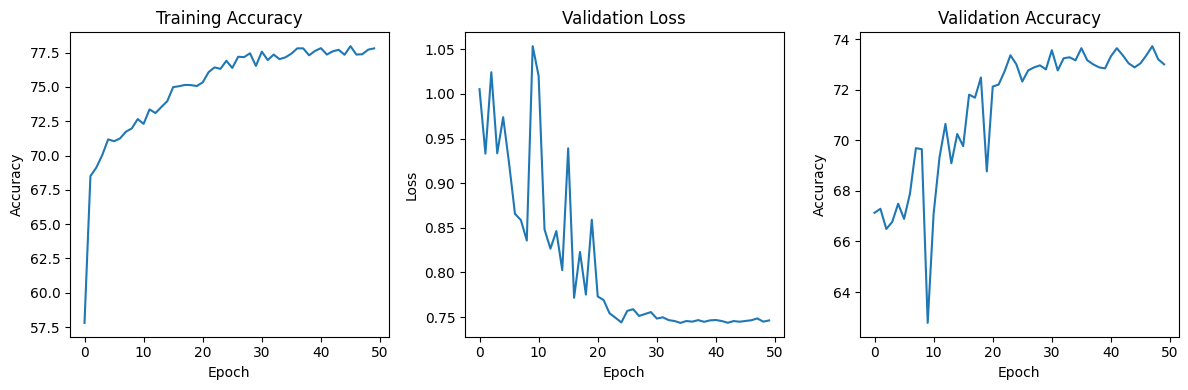

In [ ]:
# Plot training and validation metrics

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accuracy_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(validation_loss_list)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(validation_accuracy_list)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Define a function to calculate accuracy
criterion = nn.CrossEntropyLoss()
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Switch the model to evaluation mode
pytorch_model.eval()

# Initialize variables to store accuracy and loss
train_loss = 0.0
train_correct = 0
train_total = 0
test_loss = 0.0
test_correct = 0
test_total = 0

# Evaluate on training data
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        train_total += labels.size(0)

train_accuracy = 100 * train_correct / train_total
train_loss /= len(train_loader)

# Evaluate on test data
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

# Print evaluation results
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy, "%")
print('-' * 20)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy, "%")

Train Loss: 0.5333431375733877
Train Accuracy: 81.08108108108108 %
--------------------
Test Loss: 0.7462492704391479
Test Accuracy: 73.00319488817891 %


In [ ]:
# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Switch the model to evaluation mode
pytorch_model.eval()

# Evaluate on test data
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = pytorch_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print the results
print("True Labels:", y_true)
print("Predicted Labels:", y_pred)

True Labels: [6 0 6 ... 4 2 4]
Predicted Labels: [6 0 4 ... 4 2 4]


In [ ]:
# Define your classes dictionary
classes = {
    4: ('nv', 'melanocytic nevi'),
    6: ('mel', 'melanoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    1: ('bcc', 'basal cell carcinoma'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    3: ('df', 'dermatofibroma')
}

# Extract class labels from the dictionary
classes_labels = list(classes.keys())

# Print the class labels
print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


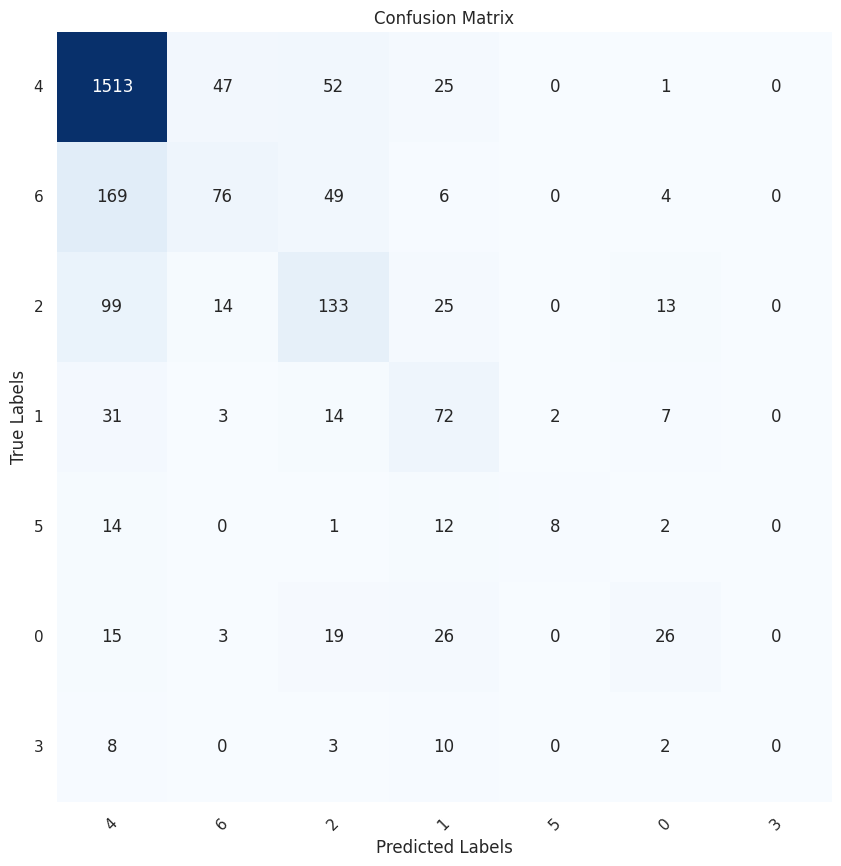

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes_labels):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.set(style="whitegrid")
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(classes_labels, rotation=45)
    ax.set_yticklabels(classes_labels, rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have already computed y_true and y_pred
plot_confusion_matrix(y_true, y_pred, classes_labels)